--- 1. Загрузка и подготовка данных ---
Размер датасета: (1338, 7)
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Пропуски в данных:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


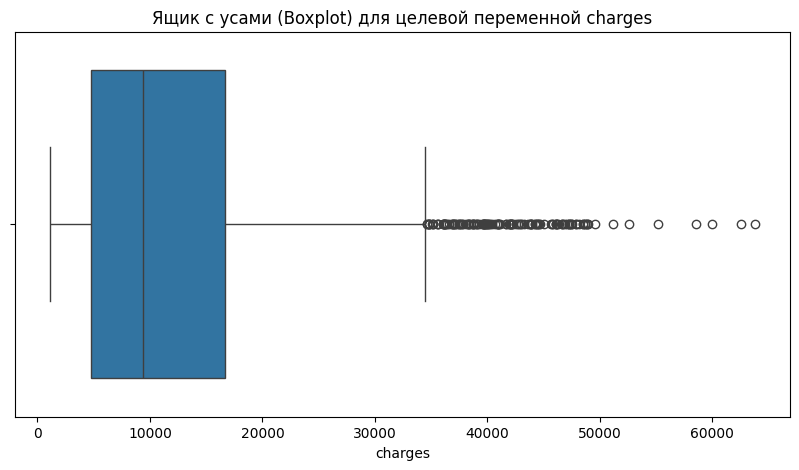


Данные после кодирования:
   age  sex     bmi  children  smoker      charges  region_northwest  \
0   19    0  27.900         0       1  16884.92400                 0   
1   18    1  33.770         1       0   1725.55230                 0   
2   28    1  33.000         3       0   4449.46200                 0   
3   33    1  22.705         0       0  21984.47061                 1   
4   32    1  28.880         0       0   3866.85520                 1   

   region_southeast  region_southwest  
0                 0                 1  
1                 1                 0  
2                 1                 0  
3                 0                 0  
4                 0                 0  


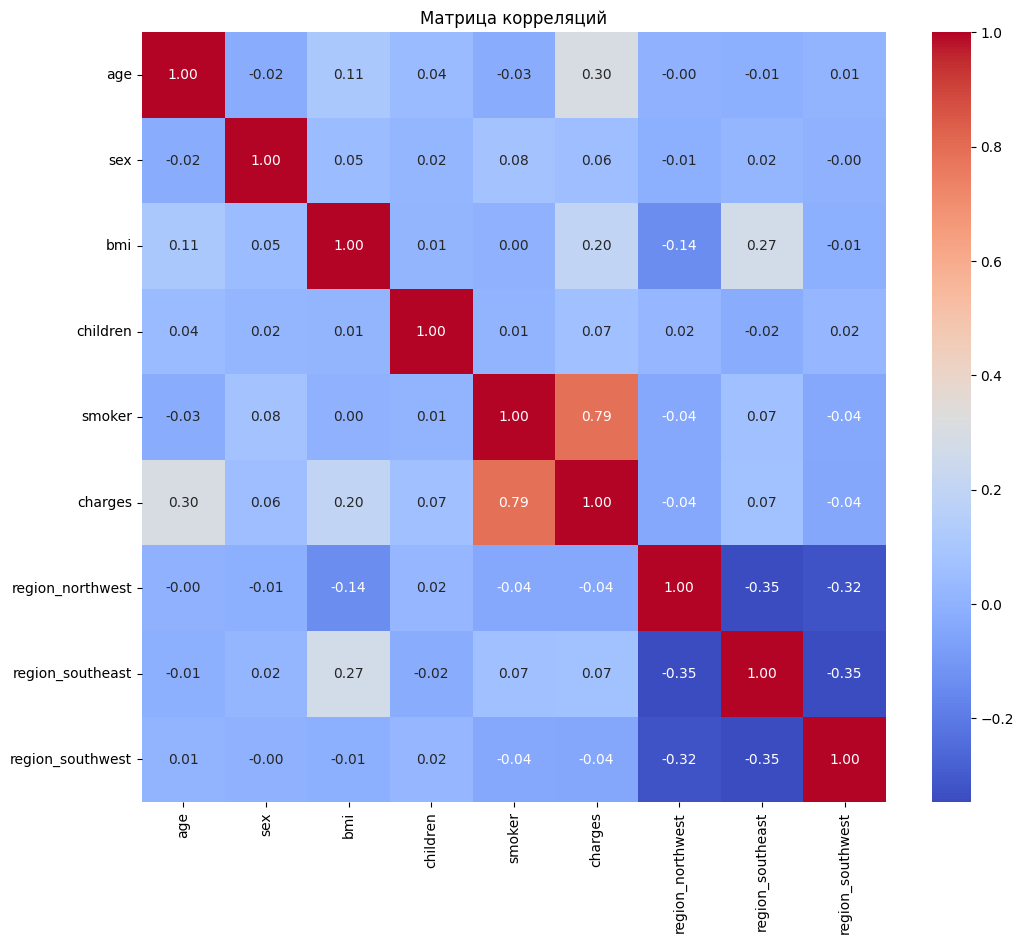


--- 2. Многомерная линейная регрессия ---
MSE (Аналитическое): 33596915.85
MSE (Градиентный спуск): 33596915.85


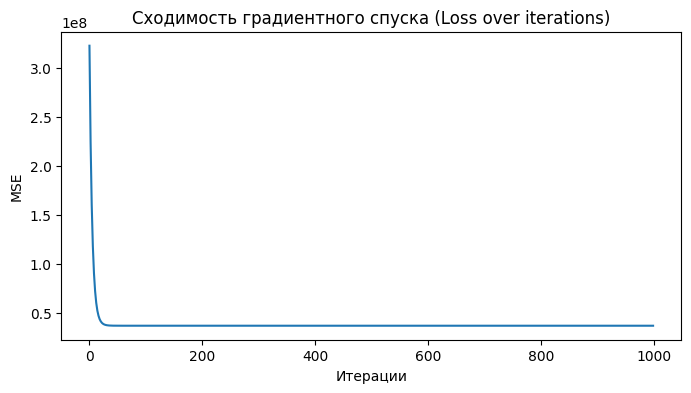


--- 3. Добавление регуляризации (Ridge / L2) ---
MSE (Ridge Аналитическое, lambda=10.0): 33685862.86
MSE (Ridge Градиентный спуск, lambda=10.0): 33685862.86

--- 4. Оценка обобщающей способности ---

Сравнение моделей по MSE на тестовых данных:
                   Model           MSE
4         Constant Model  1.553914e+08
3   Ridge (Grad Descent)  3.368586e+07
2     Ridge (Analytical)  3.368586e+07
0    Linear (Analytical)  3.359692e+07
1  Linear (Grad Descent)  3.359692e+07


/tmp/ipython-input-2443457148.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MSE', y='Model', data=results_df, palette='viridis')


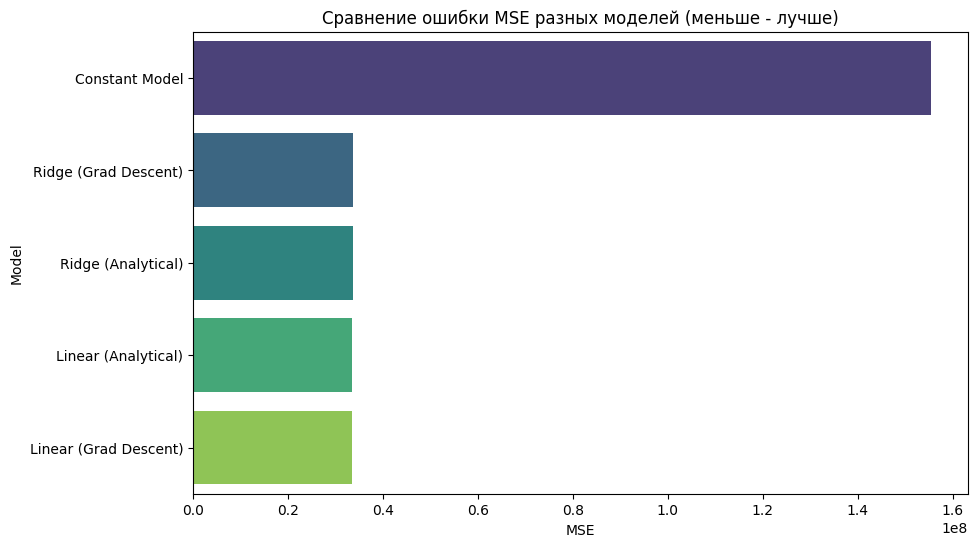

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def load_and_prepare_data(filepath):
    print("--- 1. Загрузка и подготовка данных ---")
    df = pd.read_csv(filepath)
    print(f"Размер датасета: {df.shape}")
    print(df.head())

    print("\nПропуски в данных:")
    print(df.isnull().sum())

    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df['charges'])
    plt.title('Ящик с усами (Boxplot) для целевой переменной charges')
    plt.show()

    df['sex'] = df['sex'].map({'female': 0, 'male': 1})
    df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})

    df = pd.get_dummies(df, columns=['region'], drop_first=True, dtype=int)

    print("\nДанные после кодирования:")
    print(df.head())

    plt.figure(figsize=(12, 10))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Матрица корреляций')
    plt.show()

    return df

class MyLinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000, regularization=None, lam=0.1):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.regularization = regularization
        self.lam = lam
        self.weights = None
        self.bias = None
        self.cost_history = []

    def fit_analytic(self, X, y):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]

        if self.regularization == 'L2':
            I = np.eye(X_b.shape[1])
            I[0, 0] = 0

            theta = np.linalg.inv(X_b.T.dot(X_b) + self.lam * I).dot(X_b.T).dot(y)
        else:
            theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

        self.bias = theta[0]
        self.weights = theta[1:]

    def fit_gradient_descent(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        self.cost_history = []

        for _ in range(self.n_iterations):
            y_predicted = np.dot(X, self.weights) + self.bias

            errors = y_predicted - y

            if self.regularization == 'L2':
                dw = (1 / n_samples) * np.dot(X.T, errors) + (self.lam / n_samples) * self.weights
            else:
                dw = (1 / n_samples) * np.dot(X.T, errors)

            db = (1 / n_samples) * np.sum(errors)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            cost = np.mean(errors ** 2)
            self.cost_history.append(cost)

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

df = load_and_prepare_data('/content/sample_data/insurance.csv')

X = df.drop('charges', axis=1).values
y = df['charges'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results = {}

print("\n--- 2. Многомерная линейная регрессия ---")

lr_analytic = MyLinearRegression()
lr_analytic.fit_analytic(X_train_scaled, y_train)
y_pred_analytic = lr_analytic.predict(X_test_scaled)
mse_analytic = mean_squared_error(y_test, y_pred_analytic)
results['Linear (Analytical)'] = mse_analytic
print(f"MSE (Аналитическое): {mse_analytic:.2f}")

lr_gd = MyLinearRegression(learning_rate=0.1, n_iterations=1000)
lr_gd.fit_gradient_descent(X_train_scaled, y_train)
y_pred_gd = lr_gd.predict(X_test_scaled)
mse_gd = mean_squared_error(y_test, y_pred_gd)
results['Linear (Grad Descent)'] = mse_gd
print(f"MSE (Градиентный спуск): {mse_gd:.2f}")

plt.figure(figsize=(8, 4))
plt.plot(lr_gd.cost_history)
plt.title('Сходимость градиентного спуска (Loss over iterations)')
plt.xlabel('Итерации')
plt.ylabel('MSE')
plt.show()

print("\n--- 3. Добавление регуляризации (Ridge / L2) ---")

LAMBDA = 10.0

ridge_analytic = MyLinearRegression(regularization='L2', lam=LAMBDA)
ridge_analytic.fit_analytic(X_train_scaled, y_train)
y_pred_ridge_an = ridge_analytic.predict(X_test_scaled)
mse_ridge_an = mean_squared_error(y_test, y_pred_ridge_an)
results['Ridge (Analytical)'] = mse_ridge_an
print(f"MSE (Ridge Аналитическое, lambda={LAMBDA}): {mse_ridge_an:.2f}")

ridge_gd = MyLinearRegression(learning_rate=0.1, n_iterations=1000, regularization='L2', lam=LAMBDA)
ridge_gd.fit_gradient_descent(X_train_scaled, y_train)
y_pred_ridge_gd = ridge_gd.predict(X_test_scaled)
mse_ridge_gd = mean_squared_error(y_test, y_pred_ridge_gd)
results['Ridge (Grad Descent)'] = mse_ridge_gd
print(f"MSE (Ridge Градиентный спуск, lambda={LAMBDA}): {mse_ridge_gd:.2f}")

print("\n--- 4. Оценка обобщающей способности ---")

y_pred_const = np.full(shape=y_test.shape, fill_value=y_train.mean())
mse_const = mean_squared_error(y_test, y_pred_const)
results['Constant Model'] = mse_const

results_df = pd.DataFrame(list(results.items()), columns=['Model', 'MSE'])
results_df = results_df.sort_values(by='MSE', ascending=False)

print("\nСравнение моделей по MSE на тестовых данных:")
print(results_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='MSE', y='Model', data=results_df, palette='viridis')
plt.title('Сравнение ошибки MSE разных моделей (меньше - лучше)')
plt.show()